In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
from typing import Optional

from pydantic import BaseModel, Field, ConfigDict


class File(BaseModel):
    path: str = Field(description="The path to the file to be created or modified")

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:openai/gpt-oss-120b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x108bcda90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x108bce660>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
# Tool Order Matters
# When combining structured output with additional tools, bind tools first, then apply structured output:

# # Correct
# model_with_tools = model.bind_tools([tool1, tool2])
# structured_model = model_with_tools.with_structured_output(schema)

# # Incorrect - will cause tool resolution errors
# structured_model = model.with_structured_output(schema)
# broken_model = structured_model.bind_tools([tool1, tool2])

In [6]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [34]:
from agent.states import *
from agent.prompts import *

In [8]:
def math_agent(state: dict) -> dict:
    """Breaks down a problem into simpler and understandable sub tasks."""
    user_prompt = state["user_prompt"]
    resp = llm.with_structured_output(MathPlan).invoke(
        math_agent_prompt(user_prompt)
    )
    if resp is None:
        raise ValueError("Planner did not return a valid response.")
    return resp


In [6]:
def math_agent(user_query: str) -> str:
    """Breaks down a problem into simpler and understandable sub tasks."""
    user_prompt =  user_query
    resp = llm.with_structured_output(MathPlan).invoke(
        math_agent_prompt(user_prompt)
    )
    if resp is None:
        raise ValueError("Planner did not return a valid response.")
    return resp


In [7]:
class CodeOutput(TypedDict):
    generated_code:Annotated[str, "This has the generated sympy code"]


In [17]:
import sympy

In [35]:
def sympy_code_generator_and_executor(query: str) -> dict:
    """
    Solve a mathematical query by generating and executing Sympy code.

    - Use this tool only for **numerical problem solving** (e.g., arithmetic, algebra, calculus, roots, equations).
    - Do NOT use this tool for conceptual/theoretical explanations.
    - The input is a math problem in natural language (string).
    - The tool will:
        1. Generate Sympy code relevant to the query.
        2. Execute the code safely.
        3. Return the result.
    - The output is always a dictionary with a key "Final_Result" containing a strictly **numerical value**.
      Example: {"Final_Result": 42.5}
    """
    # math_plan = math_agent(query)

    # # math_plan = state['math_plan']

    code_generation_prompt = sympy_executor_prompt(query)

    import re

    # Step 1: Generate Sympy code
    sympy_code = llm.invoke(code_generation_prompt).content

    import json 

    sympy_code = json.loads(sympy_code)

    sympy_code = sympy_code.get('generated_code', "no code found")

    # Step 2: Clean the code (remove markdown fencing if present)
    sympy_code_cleaned = re.sub(r"^```python\n|```$", "", sympy_code, flags=re.MULTILINE).strip()

    print("Generated Sympy Code:\n", sympy_code_cleaned)

    # Step 3: Execute the generated Sympy code safely
    global_vars = {"sympy": sympy}
    local_vars = {}

    try:
        exec(sympy_code_cleaned, local_vars)
        FINAL_RESULT = local_vars.get("final_answer", "No result found.")
    except Exception as e:
        FINAL_RESULT = f"Execution Error: {e}"

    print("Final Result:", FINAL_RESULT)

    return {"Final_Result": FINAL_RESULT}


In [10]:
resp = math_agent(" What are the roots of the following parabola: 3x^2 + 4x + 5 ?")

In [11]:
resp 

MathPlan(problem_understanding='We need to find the two (possibly complex) roots of the quadratic polynomial 3*x**2 + 4*x + 5 = 0.', variables={'a': 'coefficient of x^2, value 3', 'b': 'coefficient of x, value 4', 'c': 'constant term, value 5', 'x': 'unknown variable (root of the quadratic)'}, formula='Quadratic formula: roots of ax^2+bx+c=0 are x = (-b ± sqrt(b^2 - 4ac)) / (2a)', step_by_step_plan=['Introduce a symbolic variable x.', 'Define the coefficients a=3, b=4, c=5.', 'Form the quadratic equation a*x**2 + b*x + c = 0.', "Use Sympy's solve function (or quadratic_formula) to solve for x.", 'Simplify the resulting expressions, which will involve complex numbers because the discriminant is negative.'], sympy_mapping=[SympyStep(description='Create symbolic variable for the unknown.', sympy_hint="x = symbols('x')"), SympyStep(description='Assign numeric values to coefficients.', sympy_hint='a, b, c = 3, 4, 5'), SympyStep(description='Construct the equation a*x**2 + b*x + c = 0.', sym

In [12]:
str_resp = str(resp)

In [13]:
str_resp

'problem_understanding=\'We need to find the two (possibly complex) roots of the quadratic polynomial 3*x**2 + 4*x + 5 = 0.\' variables={\'a\': \'coefficient of x^2, value 3\', \'b\': \'coefficient of x, value 4\', \'c\': \'constant term, value 5\', \'x\': \'unknown variable (root of the quadratic)\'} formula=\'Quadratic formula: roots of ax^2+bx+c=0 are x = (-b ± sqrt(b^2 - 4ac)) / (2a)\' step_by_step_plan=[\'Introduce a symbolic variable x.\', \'Define the coefficients a=3, b=4, c=5.\', \'Form the quadratic equation a*x**2 + b*x + c = 0.\', "Use Sympy\'s solve function (or quadratic_formula) to solve for x.", \'Simplify the resulting expressions, which will involve complex numbers because the discriminant is negative.\'] sympy_mapping=[SympyStep(description=\'Create symbolic variable for the unknown.\', sympy_hint="x = symbols(\'x\')"), SympyStep(description=\'Assign numeric values to coefficients.\', sympy_hint=\'a, b, c = 3, 4, 5\'), SympyStep(description=\'Construct the equation a

In [36]:
resp_code = sympy_code_generator_and_executor(" What is the area of a hexagon with side 5 cm")

Generated Sympy Code:
 from sympy import symbols, sqrt, Rational, simplify

# Define the side length variable
s = symbols('s')

# Area formula for a regular hexagon: (3*sqrt(3)/2) * side^2
area_expr = (3 * sqrt(3) / 2) * s**2

# Substitute the given side length (5 cm) into the expression
final_answer = area_expr.subs(s, 5)
Final Result: 75*sqrt(3)/2


In [33]:
resp_code = sympy_code_generator_and_executor(" solve 75*sqrt(3)/2 to get a numerical value")

Generated Sympy Code:
 from sympy import sqrt, N

# Define the expression
expr = 75 * sqrt(3) / 2

# Compute its numerical (floating‑point) value
final_answer = N(expr)
Final Result: 64.9519052838329


In [23]:
from sympy import symbols, sqrt

In [24]:
# Define the constant
n = 9843765983475

# Compute the square root
final_answer = sqrt(n)

In [26]:
final_answer.evalf()

3137477.64668930

In [32]:
graph_builder = StateGraph(dict)

graph_builder.add_node("math_test", sympy_code_generator_and_executor)

graph_builder.add_edge(START, "math_test")

graph_builder.add_edge("math_test", END)

graph = graph_builder.compile()

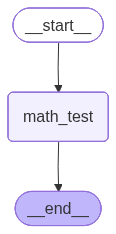

In [33]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [34]:
response = graph.invoke({"user_prompt": "What is the square root of 9843765983475 ?"})

BadRequestError: Error code: 400 - {'error': {'message': 'Tool choice is required, but model did not call a tool', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '**1. Problem Understanding**  \nWe need to determine the (principal) square root of the integer\u202f9843765983475. The task is to obtain either an exact symbolic form\u202f√9843765983475\u202for a numerical approximation (e.g., decimal) if the number is not a perfect square.\n\n---\n\n**2. Variables**  \n\n| Symbol | Description | Type |\n|--------|-------------|------|\n|\u202fN\u202f|The given integer\u202f9843765983475 | known constant |\n|\u202fr\u202f|The principal square root of\u202fN\u202f| unknown (to be found) |\n\n---\n\n**3. Relevant Concept/Formula**  \n\n- **Square‑root definition**:\u202f\\(r = \\sqrt{N}\\).  \n- If\u202fN\u202fis not a perfect square, the result is an irrational number; we can express it as `sqrt(N)` symbolically or evaluate it numerically with a desired precision.  \n- **Sympy functions**: `sqrt` for the exact radical, `N` (or `evalf`) for a numeric approximation, and optionally `is_square` to test whether\u202fN\u202fis a perfect square.\n\n---\n\n**4. Step‑by‑Step Plan**  \n\n1. **Create the integer**\u202fN\u202fin Sympy.  \n2. **Check perfect‑square status** (optional): use `N.is_square` to see if an integer square root exists.  \n3. **Form the radical**: construct the symbolic expression `sqrt(N)`.  \n4. **If a numeric answer is required**, evaluate the radical to a chosen number of decimal places using `N(expr, prec)` or `expr.evalf(prec)`.  \n5. **Return** either the exact symbolic radical (if the problem only asks for “the square root”) or the numeric approximation (if a decimal answer is desired).\n\n---\n\n**5. Sympy Mapping**  \n\n| Step | Sympy construct / function | How it is used (plain‑language description) |\n|------|---------------------------|---------------------------------------------|\n| 1. Define N | `N = Integer(9843765983475)` | Store the given integer as a Sympy `Integer`. |\n| 2. Test perfect square (optional) | `N.is_square` | Returns `True` if N = k² for some integer k; otherwise `False`. |\n| 3. Symbolic square root | `r = sqrt(N)` | Creates the exact radical expression √9843765983475. |\n| 4. Numeric approximation | `r_numeric = r.evalf(20)` (or `N(r, 20)`) | Computes a decimal approximation of the root with, e.g., 20 significant digits. |\n| 5. Output | `r` (symbolic) or `r_numeric` (numeric) | Provide the final answer in the requested form. |\n\n---\n\n**6. Next Step**  \nAnother agent should now generate the Sympy code following the mapping above, execute it, and return either the exact expression\u202f√9843765983475\u202for its numeric approximation (to a reasonable precision).'}}

In [35]:
for m in response['plan']:
    print(m)

('problem_understanding', 'We need to find the two (possibly complex) roots of the quadratic polynomial 3x^2 + 4x + 5 = 0.')
('variables', {'a': 'coefficient of x^2, value 3', 'b': 'coefficient of x, value 4', 'c': 'constant term, value 5', 'x': 'unknown variable representing the root(s) of the quadratic'})
('formula', 'Quadratic formula: For ax^2 + bx + c = 0, roots are x = (-b ± sqrt(b^2 - 4ac)) / (2a).')
('step_by_step_plan', ['Introduce a symbolic variable x.', 'Define the coefficients: a = 3, b = 4, c = 5.', 'Form the quadratic equation a*x**2 + b*x + c = 0.', "Apply the quadratic formula to obtain the two roots, or simply call Sympy's solve function on the equation.", 'Simplify the resulting expressions (Sympy will automatically handle complex numbers).'])
('sympy_mapping', [SympyStep(description='Create symbolic variable for the unknown root.', sympy_hint="x = symbols('x')"), SympyStep(description='Assign numeric values to the coefficients a, b, c.', sympy_hint='a, b, c = 3, 4, 

In [20]:
response = graph.invoke({"user_prompt": "What are the roots of the following parabola: 3x^2 + 4x + 5 ?"})


In [21]:
for m in response['plan']:
    print(m)

('problem_understanding', 'We need to find the two (possibly complex) roots of the quadratic polynomial 3x^2 + 4x + 5 = 0.')
('variables', {'a': 'coefficient of x^2, value 3', 'b': 'coefficient of x, value 4', 'c': 'constant term, value 5', 'x': 'unknown variable representing the root(s) of the quadratic'})
('formula', 'Quadratic formula: For ax^2 + bx + c = 0, roots are x = (-b ± sqrt(b^2 - 4ac)) / (2a).')
('step_by_step_plan', ['Introduce a symbolic variable x.', 'Define the coefficients: a = 3, b = 4, c = 5.', 'Form the quadratic equation a*x**2 + b*x + c = 0.', "Apply the quadratic formula to obtain the two roots, or simply call Sympy's solve function on the equation.", 'Simplify the resulting expressions (Sympy will automatically handle complex numbers).'])
('sympy_mapping', [SympyStep(description='Create symbolic variable for the unknown root.', sympy_hint="x = symbols('x')"), SympyStep(description='Assign numeric values to the coefficients a, b, c.', sympy_hint='a, b, c = 3, 4, 

In [12]:
load_dotenv()

True

In [64]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("High school helper AI agent for solving maths andd physics problems")

{'query': 'High school helper AI agent for solving maths andd physics problems',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://math-gpt.org/',
   'title': 'MathGPT - AI Math Solver - Math Solver & Homework Helper',
   'content': 'MathGPT Math Solver and AI Calculator MathGPT is your all-in-one math solver and AI tutor, serving as an AI math calculator that solves algebra, calculus, chemistry, and physics problems, making it the ultimate homework helper and AI math solver. MathGPT is the first to provide on-demand, AI-powered video explanations with engaging animations and diagrams for any homework question, making it the most interactive homework helper and math solver. With features like step-by-step explanations, personalized AI videos, and interactive quizzes, MathGPT helps make learning math easier and more engaging. Yes, MathGPT is an Math Solver App and Site that will solve math problems simply by dragging and dropping photos into the

In [65]:
tool.invoke('Can you explain what sympy functions used foe calculating sin values')

{'query': 'Can you explain what sympy functions used foe calculating sin values',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://docs.sympy.org/latest/modules/functions/elementary.html',
   'title': 'sympy.functions.elementary.complexes',
   'content': '*class* sympy.functions.elementary.complexes.re(*arg*)¶ *class* sympy.functions.elementary.complexes.im(*arg*)¶ re(x) *class* sympy.functions.elementary.complexes.sign(*arg*)¶ *class* sympy.functions.elementary.complexes.Abs(*arg*)¶ x**2 *class* sympy.functions.elementary.complexes.arg(*arg*)¶ >>> from sympy.abc import x *class* sympy.functions.elementary.complexes.conjugate(*arg*)¶ *class* sympy.functions.elementary.complexes.polar\\_lift(*arg*)¶ *class* sympy.functions.elementary.complexes.principal\\_branch(*x*, *period*)¶ *class* sympy.functions.elementary.trigonometric.sin(*arg*)¶ >>> from sympy.abc import x *class* sympy.functions.elementary.trigonometric.cos(*arg*)¶ >>> from sympy.abc 

In [ ]:
result_crawler = smartcrawler.invoke(


In [16]:
import math

In [33]:
def sqrt(a:int) -> float:
    """
    Find square root of a number
    """

    return math.sqrt(a)

In [21]:
ans = sqrt(36)
ans

6.0

In [34]:
tools = [tool, sqrt]

In [35]:
llm_with_tool = llm.bind_tools(tools)

In [36]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [37]:
## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


In [26]:
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)



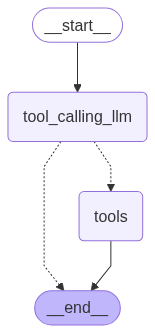

In [38]:
## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
response=graph.invoke({"messages":"Is AI agent going to be the next big thing according to the latest news"})

In [44]:
response['messages'][-1].content

'{"query": "AI agents next big thing latest news 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/walmart-ai-driven-retail-transformation-implications-amazon-market-2509/", "title": "Walmart’s AI-Driven Retail Transformation and Its Implications for Amazon and the Market - AInvest", "score": 0.8170061, "published_date": "Fri, 05 Sep 2025 00:52:56 GMT", "content": "The agentic AI market is projected to grow from $2.9 billion in 2024 to $48.2 billion by 2030, with 60% of enterprise AI deployments in 2025 incorporating agentic capabilities . Walmart’s early adoption of this technology positions it to capitalize on this growth. By embedding AI into its supply chain, customer service, and employee workflows, Walmart is creating a flywheel effect: enhanced efficiency drives lower costs, which in turn fund further AI innovation.", "raw_content": null}, {"url": "https://www.csoonline.com/article/4047974/agentic-ai-a-cisos-secur

In [45]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Is AI agent going to be the next big thing according to the latest news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_17f49cdd-c03e-4de9-bcda-e8fcfd74ca9f)
 Call ID: fc_17f49cdd-c03e-4de9-bcda-e8fcfd74ca9f
  Args:
    query: AI agents next big thing latest news 2024
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI agents next big thing latest news 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/walmart-ai-driven-retail-transformation-implications-amazon-market-2509/", "title": "Walmart’s AI-Driven Retail Transformation and Its Implications for Amazon and the Market - AInvest", "score": 0.8170061, "published_date": "Fri, 05 Sep 2025 00:52:56 GMT

In [46]:

response=graph.invoke({"messages":"What is the square root of 9843765983475?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the square root of 9843765983475?
================================== Ai Message ==================================
Tool Calls:
  sqrt (fc_13a8ea6a-2c75-4f29-9a7b-7b24e78f33d6)
 Call ID: fc_13a8ea6a-2c75-4f29-9a7b-7b24e78f33d6
  Args:
    a: 9843765983475
================================= Tool Message =================================
Name: sqrt

3137477.646689296


# ReAct Agent Architecture 

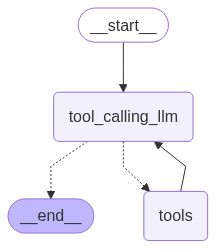

In [63]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
response=graph.invoke({"messages":"Can you write simple code in sympy to calculate roots of an equation"})

In [67]:
response

{'messages': [HumanMessage(content='Can you write simple code in sympy to calculate roots of an equation', additional_kwargs={}, response_metadata={}, id='ed6a3730-f7b5-47a3-a8c4-f9c85251dcc7'),
  AIMessage(content='Sure! Below is a short, self‑contained example that shows how to use **SymPy** (the Python symbolic mathematics library) to find the roots of an algebraic equation.\n\n```python\n# -------------------------------------------------\n#  SymPy – Finding the roots of an equation\n# -------------------------------------------------\n#  1. Install SymPy (if you haven\'t already):\n#       pip install sympy\n#\n#  2. Run the script / paste it into a Jupyter notebook.\n# -------------------------------------------------\n\nimport sympy as sp\n\n# -------------------------------------------------\n#  Define the symbolic variable(s)\n# -------------------------------------------------\nx = sp.Symbol(\'x\')          # the variable we will solve for\n\n# -------------------------------

In [68]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you write simple code in sympy to calculate roots of an equation
================================== Ai Message ==================================

Sure! Below is a short, self‑contained example that shows how to use **SymPy** (the Python symbolic mathematics library) to find the roots of an algebraic equation.

```python
# -------------------------------------------------
#  SymPy – Finding the roots of an equation
# -------------------------------------------------
#  1. Install SymPy (if you haven't already):
#       pip install sympy
#
#  2. Run the script / paste it into a Jupyter notebook.
# -------------------------------------------------

import sympy as sp

# -------------------------------------------------
#  Define the symbolic variable(s)
# -------------------------------------------------
x = sp.Symbol('x')          # the variable we will solve for

# ------------------------------------

In [48]:
response=graph.invoke({"messages":"Give me the recent ai news and then tell me the square root of 81"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then tell me the square root of 81
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_23b30b46-3fc4-431d-b7d8-16c8fb0d788b)
 Call ID: fc_23b30b46-3fc4-431d-b7d8-16c8fb0d788b
  Args:
    query: latest AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.finextra.com/newsarticle/46539/banks-set-to-accelerate-spend-on-ai-as-productivity-surges", "title": "Banks set to accelerate spend on AI as productivity surges - Finextra Research", "score": 0.76385427, "published_date": "Wed, 03 Sep 2025 23:02:11 GMT", "content": "/ai### Lloyds puts leadership team through AI training programme

In [49]:
response=graph.invoke({"messages":"Hello my name is Rutvi"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Rutvi
================================== Ai Message ==================================

Hello Rutvi! 👋 Nice to meet you. How can I assist you today?


In [50]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I’m sorry, but I don’t have any information about your name. If you’d like me to address you by a particular name, just let me know!


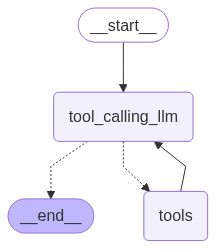

In [51]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
config={"configurable":{"thread_id":"2"}}

response=graph.invoke({"messages":"Hi my name is Rutvi"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Rutvi', additional_kwargs={}, response_metadata={}, id='0eaf4135-b847-46b9-a04e-b0d58a91f090'),
  AIMessage(content='Hello Rutvi! 👋 Nice to meet you. I’m ChatGPT—here to help with answers, ideas, or anything you’d like to chat about. How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "Hi my name is Rutvi". We should respond friendly, introduce ourselves, maybe ask how can help.'}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 1383, 'total_tokens': 1458, 'completion_time': 0.149476523, 'prompt_time': 0.05083327, 'queue_time': 0.186275343, 'total_time': 0.200309793}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_213abb2467', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b0352e5f-fb5e-4989-9ce7-750aea4ee828-0', usage_metadata={'input_tokens': 1383, 'output_tokens': 75, 'total_tokens': 1458})]}

In [55]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Rutvi! 🌟 How can I help you today?


In [56]:

from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [57]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

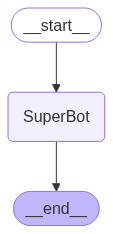

In [58]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [59]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Rutvi And I like Surfing"},config)


{'messages': [HumanMessage(content='Hi,My name is Rutvi And I like Surfing', additional_kwargs={}, response_metadata={}, id='0ba44bc3-4d0b-4be1-a0a9-c9f77f946237'),
  AIMessage(content="Hello Rutvi! 👋 Great to meet you. Surfing sounds like an awesome hobby—there’s something magical about catching a wave and feeling that rush. Do you have a favorite spot you like to surf, or are you just getting started? I'd love to hear more about your surfing adventures!", additional_kwargs={'reasoning_content': 'We need to respond as ChatGPT. The user says "Hi, My name is Rutvi And I like Surfing". Probably respond friendly, ask about surfing, etc. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 83, 'total_tokens': 192, 'completion_time': 0.216779086, 'prompt_time': 0.002895762, 'queue_time': 0.186194118, 'total_time': 0.219674848}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason

In [60]:

# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Rutvi And I like Surfing"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hello Rutvi! 👋 Great to meet you. Surfing sounds like an amazing hobby—there’s something special about riding the waves and feeling that blend of freedom and focus. \n\nDo you have a favorite spot you like to surf, or are you looking for tips on gear, techniques, or maybe some new surf destinations? I’d love to hear more about your surfing adventures! 🌊🏄\u200d♂️', additional_kwargs={'reasoning_content': 'We need to respond as ChatGPT. The user says "Hi, My name is Rutvi And I like Surfing". Probably respond friendly, ask about surfing, etc. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 83, 'total_tokens': 216, 'completion_time': 0.264489985, 'prompt_time': 0.002924232, 'queue_time': 0.186231207, 'total_time': 0.267414217}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_3a688838c3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ebe88b07-0

In [61]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Rutvi And I like Surfing"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Rutvi And I like Surfing', additional_kwargs={}, response_metadata={}, id='76714ad5-332f-42dd-9a93-55c78817c58f'), AIMessage(content='Hello Rutvi! 👋 Great to meet you. Surfing sounds like an amazing hobby—there’s something special about riding the waves and feeling that blend of freedom and focus. \n\nDo you have a favorite spot you like to surf, or are you looking for tips on gear, techniques, or maybe some new surf destinations? I’d love to hear more about your surfing adventures! 🌊🏄\u200d♂️', additional_kwargs={'reasoning_content': 'We need to respond as ChatGPT. The user says "Hi, My name is Rutvi And I like Surfing". Probably respond friendly, ask about surfing, etc. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 83, 'total_tokens': 216, 'completion_time': 0.264489985, 'prompt_time': 0.002924232, 'queue_time': 0.186231207, 'total_time': 0.267414217}, 'model_name': 'openai/gpt-oss-

In [62]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi,My name is Rutvi And I like Surfing"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi,My name is Rutvi And I like Surfing']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e9c8ccb5-8522-4735-85c5-21e63e0d488e', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi,My name is Rutvi And I like Surfing', additional_kwargs={}, response_metadata={}, id='5694ed12-aec2-4e4f-88a2-be72061f84f8')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '7a51946f-4b8d-46c3-a10b-75445a4219d0', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:ee084c3b-af32-59e1-eecc-a45ee84b2b82'}, 'parent_ids': ['e9c8ccb5-8522-4735-85c5-21e63e0d488e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi,My name is Rutvi And I like Surfing', additional_k